<a href="https://colab.research.google.com/github/Sara-Samer/text-similarity-detector/blob/main/text_similarity_models_with_doc2vec_and_tf_idf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I think text preprocessing needs special processing for:

*   it's, they're, ... etc
*   on-site, geo-location
*   TAs, GP



# Google sheet setup and data splitting
---

google sheet link: [sheet](https://docs.google.com/spreadsheets/d/1TgsnSPK7k6ErLuC2P_eaKL1hk0bUglwlrGReVfFIK1M/edit?usp=sharing)

## pip setup & imports

In [ ]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


In [ ]:
!pip install contractions

In [ ]:
!pip install python-Levenshtein

In [ ]:
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# Setting random seed
seed = 123

# Data manipulation/analysis
import numpy as np
import pandas as pd

import gensim
from gensim.parsing.preprocessing import preprocess_string
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Data partitioning
import re, random, string
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import numpy.linalg as la
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from gensim import models
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

#Parameter tuninig
import itertools

## sheet and dataframe

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open('GP Data Set').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

In [ ]:
df = pd.DataFrame.from_records(rows[1:], columns=['title', 'description'])
df.head()

,title,description
0,Ghost Writer II,"The project idea is that while people writing on the papers there is a depth camera provided by us in front of the paper tracking the pen dimensions while writing and in real-time, our software transfers everything is written on the paper into pdf or any editable format txt, word...etc \nWe choose this project to enable people to keep using papers as they want and have their written data as a pdf or any an editable format so it’s very easy to be shared and more readable than handwriting."
1,CV shortlisting,"Sorting resumes according to job description for the hiring process automatically using NLP model (doc2vec, word2vec)"
2,MedAlarm,"Healthcare application fully responsible for patients’ bottles /needles/ pens potion every X hours or days and after %90 consumption of any it automatically generates an alert to recharge the required with available pharmacies in addition to an online chat to communicate with your private doctor for any questionnaires also you can find possible replaceable medicines in case of rare of any and a ChatBot to answer your urgent questions in case your doctor is busy, finally the main target of our app is elder and busy people who usually forgot to take their medicines.\n"
3,Android Attendance App,"This project is primarily an application for on-site attendance recording, where we provide on-site attendance to make the process easier for TAs, avoid wasted time, students being distracted and to save the TAs a lot of trouble by automating the process by which the attendance gets recorded in the database, we also use geo-location as a security measure to prevent students from faking attendance.\nOur application also provides other features like Announcements which helps students stay updated on anything related to any of their courses so that they wouldn’t miss any news, we also have a deadline feature which will help in reminding students of any deadlines they may have forgotten about, as well as a forum feature to allow students to ask questions and have them answered by any other student, TA or Professor.\n"
4,Attendance system and platform solution,"The project provides a system that uses students’ mobile phones existed in the lecture room as an indicator for their attendance. Each lecture’s attendance will be then shared with internal subsystems (Console app & mobile app) along with external systems (ex. FCAI Ecom).\nIn the beginning of the lecture, the instructor will have to start the lecture through the system’s console app.\nOnce the lecture started a time counter will keep counting the lectures time and a session of capturing attendance will start.\nMeanwhile, students will have to install and register in a mobile app that we designed, the app sends the students’ data to our server so that they can be validated and stored in the database. Once the student is in the lecture, he/she will have to use their phones to connect to an access point that is set to cover the lecture room’s range.\nThe console app will update the server with the new addresses (in the range) list continuously. The server is to filter the addresses and will use them to assign attendance to students registered in the current lecture’s subject.\nThe attendance data recorded in lecture will be shared with the console app to be available to instructors and can also be shared with other systems like the FCAI Ecom. also, with the mobile app for students by sending to each student his or her personal attendance data.\n"


In [ ]:
# df = df[df['description'].apply(lambda x: len(x.split()) > 150 )]
text_corpus = df['description'].values
len(text_corpus)

185

In [ ]:
pd.set_option('display.max_colwidth', None)
df.head(1)

,title,description
0,Ghost Writer II,"The project idea is that while people writing on the papers there is a depth camera provided by us in front of the paper tracking the pen dimensions while writing and in real-time, our software transfers everything is written on the paper into pdf or any editable format txt, word...etc \nWe choose this project to enable people to keep using papers as they want and have their written data as a pdf or any an editable format so it’s very easy to be shared and more readable than handwriting."


### abbreviation

In [ ]:
abbr_worksheet = gc.open('abbr').sheet1
abbr_rows = abbr_worksheet.get_all_values()
abbr_df = pd.DataFrame.from_records(abbr_rows[1:], columns=['abbr', 'expantion'])
abbr_df.head()

,abbr,expantion
0,TA,Teaching Assistant
1,ADHD,attention deficit hyperactivity disorder
2,CNN,convolutional neural network
3,IoT,internet of things
4,MBTI,Myers-Briggs Type Indicator


In [ ]:
abbr_dic = {}
for i in abbr_df.index:
    if len(abbr_df["abbr"][i]) > 0:
        abbr_dic[abbr_df["abbr"][i]] = abbr_df["expantion"][i]
abbr_dic

{'TA': 'terminal adapter',
 'ADHD': 'attention deficit hyperactivity disorder',
 'CNN': 'convolutional neural network',
 'IoT': 'internet of things',
 'MBTI': 'Myers-Briggs Type Indicator',
 'UMTS': 'Universal Mobile Telecommunication Systems',
 'CO': 'central office',
 'RAN': 'Radio Access Network',
 'RFID': 'radio frequency identification',
 'RTL': 'Register Transfer Level',
 'TTS': 'text-to-speech',
 'UAV': 'Unmanned aerial vehicle',
 'HLS': 'High Level Synthesis',
 'ICs': 'Integrated Circuits',
 'ITS': 'Intelligent Transportation Systems',
 '#!': 'Crunchbang Linux',
 '2D': 'two-dimensional',
 '2FA': 'two-factor authentication',
 '2G': 'second generation',
 '3D': 'three-dimensional',
 '3G': '3rd Generation',
 '3GPP': '3rd Generation Partnership Project',
 '5G': '5th Generation',
 '24x7': '24 hours a day, seven days a week',
 '24/7': '24 hours a day, seven days a week',
 'AA': 'Anti-alias',
 'AAC': 'Advanced Audio Coding',
 'AAM': 'autmoatic acoustic management',
 'AAS': 'as a servic

# Custom preprocessing

In [ ]:
# import library
import contractions
# contracted text
text = '''This project is primarily an application for on-site attendance recording, 
where we provide on-site attendance to make the process easier for TAs, avoid wasted time, 
students being distracted and to save the TAs a lot of trouble by automating the process by which the attendance gets 
recorded in the database, we also use geo-location as a security measure to prevent students from faking attendance.
Our application also provides other features like Announcements which 
helps students stay updated on anything related to any of their courses 
so that they wouldn’t miss any news, we also have a deadline feature which 
will help in reminding students of any deadlines they may have forgotten about, 
as well as a forum feature to allow students to ask questions and have them 
answered by any other student, TA or Professor.
'''
# strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords

def preprocess_text(text):
    text = contractions.fix(text)
    text = strip_multiple_whitespaces(text)
    text = re.sub(r"-+", '', text)
    text = strip_numeric(text)
    text = strip_punctuation(text)
    text = remove_stopwords(text)


print('----'*10)
print(" ".join(tfidf_analyzer(text)))
print(" ".join(preprocess_string(text, filters)))
print('----'*10)
# print(" ".join(TfidfVectorizer(analyzer=tfidf_analyzer).build_analyzer()(text)))

----------------------------------------
teach assistant
project primarily application on site attendance record provide on site attendance process easy ta avoid wasted time student distract save ta lot trouble automate process attendance get record database use geo location security measure prevent student fake attendance application provide feature like announcement help student stay update related course wouldn’t miss news deadline feature help remind student deadline forget about forum feature allow student ask question answer student ta professor
----------------------------------------


# TF-IDF model


---



---



In [ ]:
def lemmatise_text(tokens):
    pos_map = {'J': 'a', 'N': 'n', 'R': 'r', 'V': 'v'}
    pos_tags = pos_tag(tokens)
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t, pos=pos_map.get(p[0], 'v')) for t, p in pos_tags]
    return tokens
def tfidf_analyzer(text):
    stop_words = set(stopwords.words("english"))
    removed_punctuation = re.sub(r'[^\w\s]', '', text)
    removed_extra_whitespace = " ".join(removed_punctuation.split())
    lower_text = removed_extra_whitespace.lower()
    word_tokens = word_tokenize(lower_text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    lemmatised_text = lemmatise_text(filtered_text)
    return lemmatised_text

In [ ]:
train_set = text_corpus
vectorizer = TfidfVectorizer(analyzer=tfidf_analyzer)
trainVectorizerArray = vectorizer.fit_transform(train_set).toarray()

In [ ]:
new_doc = "an automated way so the attendance gets recorded in the database on-site with geo-location as a security measure to prevent students from faking attendance."
sk_sims = []
test_set = [new_doc]
testVectorizerArray = vectorizer.transform(test_set).toarray()
cos_sim = lambda a, b : round(np.inner(a, b)/(la.norm(a)*la.norm(b)), 3)

for i in range(len(trainVectorizerArray)):
    vector = trainVectorizerArray[i]
    for testV in testVectorizerArray:
        cosine = cos_sim(vector, testV)
        sk_sims.append((i, cosine))


In [ ]:
for i in sorted(sk_sims, key=lambda item: -item[1])[:10]:
    print(f"{df['title'].iloc[i[0]]} : {str(i[1])}")
    print("-"*10)

Android Attendance App : 0.552
----------
Attendance system and platform solution : 0.258
----------
SoEdu : 0.097
----------
Rotcennoc : 0.073
----------
Prezenta : 0.052
----------
among things : 0.051
----------
NoCap : 0.05
----------
AMAN : 0.049
----------
Engzly : 0.047
----------
TinyEye : 0.046
----------


# Doc2Vec model


---



---



In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_sentence(text):
    tokens = text.split()
    pos_map = {'J': 'a', 'N': 'n', 'R': 'r', 'V': 'v'}
    pos_tags = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(t.lower(), pos=pos_map.get(p[0], 'v')) for t, p in pos_tags]
    return " ".join(tokens)
filters=[lambda x: x.lower(), remove_stopwords, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, lemmatize_sentence]

In [ ]:
# filters=[lambda x: x.lower(), remove_stopwords, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, lemmatize_sentence]
processed_corpus = [preprocess_string(s, filters) for s in text_corpus]
tagged_corpus = [TaggedDocument(d, [i]) for i, d in enumerate(processed_corpus)]

In [ ]:
model = Doc2Vec(tagged_corpus, dm=0, vector_size=200, window=2, min_count=1, epochs=100, hs=1)

In [ ]:
new_doc = "an automated way so the attendance gets recorded in the database on-site with geo-location as a security measure to prevent students from faking attendance."
new_doc = gensim.parsing.preprocessing.preprocess_string(new_doc, filters)
test_doc_vector = model.infer_vector(new_doc)
sims = model.dv.most_similar(positive = [test_doc_vector])

In [ ]:
for s in sims:
    print(f"{df['title'].iloc[s[0]]} : {str(s[1])}")
    print("-"*10)

Android Attendance App : 0.6554398536682129
----------
Attendance system and platform solution : 0.3762730062007904
----------
My Diary : 0.37561342120170593
----------
sDrive : 0.3214775025844574
----------
Baseera : 0.32027459144592285
----------
JAC&D : 0.32014667987823486
----------
Umbrella : 0.2997171878814697
----------
Anima Chaotic : 0.2981669306755066
----------
AntiCrocker : 0.2921746075153351
----------
Human Resources Information System : 0.285762220621109
----------


# Parameters tuning 
(no need to review right now)

In [ ]:
test_data = [
             {
                'description': "an automated way so the attendance gets recorded in the database on-site with geo-location as a security measure to prevent students from faking attendance.",
                'title_regex': 'Attendance'
            }
             ]

In [ ]:
dm = [1, 0]
hs = [1, 0]
window = [1, 2, 3, 4, 5]
vector_size = [10, 20, 50, 70, 100, 150, 200]
params_list = [
              {'dm': item[0], 'vector_size': item[1], 'window': item[2], 'hs': item[3]} 
              for item in list(itertools.product(*[dm,vector_size,window,hs]))
              ]

In [ ]:
def evaluation_doc2vec(data_list, params, processed_corpus, top=10):
    # preprocess corpus
    tagged_corpus = [TaggedDocument(d, [i]) for i, d in enumerate(processed_corpus)]  
    
    # preprocess the test dataset
    for gp in data_list:
        gp['desc_preproc'] = preprocess_string(gp['description'], filters=filters)
        gp['regex'] = re.compile(gp['title_regex'])

    score_list = []
    for param in params:
        param['score'] = 0
        model = None
        model = Doc2Vec(tagged_corpus,
                        dm=param['dm'], 
                        vector_size=param['vector_size'], 
                        window=param['window'], 
                        min_count=1, 
                        epochs=10, 
                        hs=param['hs'])
        for gp in data_list:
            new_doc = gp['desc_preproc']
            test_doc_vector = model.infer_vector(new_doc)
            sims=model.dv.most_similar(positive=[test_doc_vector])
            top_sims = sims[:10]
            for i in range(len(top_sims)):
                # print(df['title'].iloc[top_sims[i][0]],  gp['regex'].match(df['title'].iloc[top_sims[i][0]]))
                if gp['regex'].search(df['title'].iloc[top_sims[i][0]]):
                    param['score'] = param['score'] + (top - i + 1)
                    # print(param['score'] + (top - i + 1))
            # return
        score_list.append(param)
        # try:
        # except Exception as error:
        #     print(f'Cannot evaluate model with parameters {param} because of error: {error}')
        #     continue
        
    return score_list

In [ ]:
print(re.compile("Attendance").search("Android Attendance App"))

None


In [ ]:
score_doc2vec = evaluation_doc2vec(test_data, params_list, processed_corpus)

In [ ]:
score_doc2vec = pd.DataFrame(score_doc2vec)
score_doc2vec = score_doc2vec.sort_values(by=['score'], ascending=False)
print(score_doc2vec.head(15))

     dm  vector_size  window  hs  score
70    0           10       1   1     11
88    0           20       5   1     11
102   0           70       2   1     11
100   0           70       1   1     11
98    0           50       5   1     11
96    0           50       4   1     11
94    0           50       3   1     11
92    0           50       2   1     11
90    0           50       1   1     11
86    0           20       4   1     11
108   0           70       5   1     11
84    0           20       3   1     11
82    0           20       2   1     11
80    0           20       1   1     11
78    0           10       5   1     11


The project idea is that while people writing on the papers there is a depth camera provided by us in front of the paper tracking the pen dimensions while writing and in real-time, our software transfers everything is written on the paper into pdf or any editable format txt, word...etc 
We choose this project to enable people to keep using papers as they want and have their written data as a pdf or any an editable format so it’s very easy to be shared and more readable than handwriting


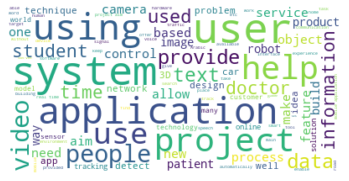

In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#loading all necessary libraries
import numpy as np
import pandas as pd

import string
import collections
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.cm as cm
import matplotlib.pyplot as plt

all_gps = []

for text in df['description'].values:
    all_gps.append(text.strip(string.punctuation))

print(all_gps[0])
final_text = " ".join(all_gps)
stopwords = set(STOPWORDS)
stopwords.update(["will", "s", "1","e","t"])
wordcloud_spam = WordCloud(stopwords=stopwords, background_color="white", max_font_size=50, max_words=100).generate(final_text)
# plt.figure(figsize = (15,15))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()